In [1]:
%matplotlib inline

In [2]:
import time
import matplotlib.pyplot as plt
import numpy as np
import GPy
import GPyOpt

## Introduction
Recently, Bayesian optimisation has been successfully applied to the problem of hyperparameter tuning in an effort popularised as AutoML. In the following, we will tune four hyperparameters for a logistic regression model trained on the MNIST dataset. The problem has been chosen from a set of benchmarks often used for hyperparameter tuning. [[Snoek, 2012]](https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf)

First, we tune the hyperparameters using __Bayesian optimisation__ with [GPyOpt](https://github.com/SheffieldML/GPyOpt). Subsequently, we conduct a comparison with tuning via __random search__, which has been shown to be surprisingly effective. [[Bergstra, 2012]](http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf) The results show that fine tuning with Bayesian optimisation is more effective and incurs little computational overhead. 

## Import MNIST data

In [3]:
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.utils import check_random_state
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [4]:
# Choosing n_iter for SGDClassifier is deprecated but we need it to reproduce our result
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [29]:
# Load dataset and shuffle it
mnist = fetch_mldata('MNIST original')
X = mnist.data.astype('float64')
y = mnist.target
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))

In [6]:
print("Size of data = {}".format(X.shape))

Size of data = (70000, 784)


In [7]:
# Perform a train-test split for validation, 
# a standard scaler transforms the data in each dimension to zero mean and unit variance 
train_samples = 5000
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=train_samples, test_size=10000)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [8]:
X_train.shape

(5000, 784)

## Define classification model and search space

In the following, we set up our logistic regression model. Note that the model is trained via mini-batch stochastic gradient descent, which is done by using sklearn's `SGDClassifier` and the `partial_fit()` method.

We will be tuning the following four hyperparameters:
 1. Learning rate for SGD $\in [0,1]$ (log scale)
 2. $l_2$ regularisation parameter $\in [0,1]$ (log scale)
 3. Number of learning epochs $\in [5,200]$
 4. Mini-batch size $\in [20,2000]$
 

In [9]:
def next_batch(X, y, batch_size):
    for i in np.arange(0, X.shape[0], batch_size):
        yield (X[i:i + batch_size], y[i:i + batch_size])

In [10]:
classes = np.unique(y)
gamma = 0.05                    # learning rate
alpha = 50. / train_samples     # l2 regulariser
n_iter = 100                    # learning epochs
batch_size = 200                # mini batch size

clf = SGDClassifier(loss = 'log',
                    penalty = 'l2',
                    alpha = alpha,
                    learning_rate = 'constant',
                    eta0 = gamma,
                    n_iter = 1)

In [11]:
start = time.time()
for i in range(n_iter):
    for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
        clf.partial_fit(X_batch, y_batch, classes=classes)
end = time.time()

sparsity = np.mean(clf.coef_ == 0) * 100
score = clf.score(X_test, y_test)
print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)
print("Time elapsed: {}".format(end-start))

Sparsity with L2 penalty: 15.82%
Test score with L2 penalty: 0.8058
Time elapsed: 17.1719620228


## Wrapper function for scoring model
In Bayesian optimisation, we treat the objective function as a black box. In the case of hyperparameter tuning, we define the objective function as the validation error of our model given a set of hyperparameters as the input. Here, we choose a random initialisation as our starting benchmark. Note the validation error of 0.16 and training time of 15.7 seconds.

In [12]:
def fit_svr_val(x):
    x = np.atleast_2d(x)
    fs = np.zeros((x.shape[0],1))
    for i in range(x.shape[0]):
        fs[i] = 0
        gamma = np.exp(x[i,0]) # log scale
        alpha = np.exp(x[i,1]) # log scale
        n_iter = int(x[i,2])
        batch_size = int(x[i,3])
        clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, 
                            learning_rate='constant', eta0=gamma, 
                            n_iter=1)
        for j in range(n_iter):
            for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
                clf.partial_fit(X_batch, y_batch, classes=classes)

        score = clf.score(X_test, y_test)
        fs[i] = 1 - score # classification error
    return fs

In [13]:
x = np.array([-2, np.log(50 / train_samples), 100, 200])
start = time.time()
print(fit_svr_val(x))
end = time.time()
print("Time elapsed: {}".format(end-start))

[[ 0.1598]]
Time elapsed: 15.7178440094


## Bayesian Optimisation

First, we define the number of optimisation iterations. This is the number of function evaluations, ie we will be sampling and training 100 different logistic regression models. Thus, we can expect the process to take roughly 2000 seconds.  

Bayesian optimisation requires us to retrain the GP surrogate at every iteration, which incurs a training complexity of $\mathcal{O}(n^3)$. Hence to reduce the algorithmic overhead, the number of optimisation iterations is typically kept below 300.

In [14]:
opt_iter = 100

Second, we set up the domain of the search space. Of the four hyperparameters, two are continuous and two are discrete. Also note that the learning rate and regularisation constant are optimised in the log space.

In [15]:
domain =      [{'name': 'gamma_log','type': 'continuous', 'domain': (-6,0)}, 
               {'name': 'alpha_log','type': 'continuous', 'domain': (-6,0)},
               {'name': 'n_iter','type': 'discrete', 'domain': (5,200)},
               {'name': 'batch_size','type': 'discrete', 'domain': (20,2000)}]

Third, we initialise the Bayesian optimiser. We use a GP as our surrogate model and Expected Improvement Criterion as our acquisition function.

We also need to choose an initial design of experiments (DoE) to serve as a starting point for the GP surrogate. Here, we initialise a random design consisting of $5D$ points. Other initial design strategies include Sobol sequences or Latin hypercubes.

In [16]:
n_dim = len(domain)
n_initial = 5 * n_dim
bayes_opt = GPyOpt.methods.BayesianOptimization(f = fit_svr_val,                   
                                                domain = domain, 
                                                model_type = 'GP',
                                                acquisition_type = 'EI',
                                                exact_feval = True,
                                                initial_design_numdata = n_initial, 
                                                initial_design_type = 'random',
                                                num_cores = 2)   

In [17]:
X_init = bayes_opt.X
Y_init = bayes_opt.Y
print(X_init.shape)

(20, 4)


In [18]:
start = time.time()
bayes_opt.run_optimization(max_iter = opt_iter)
end = time.time()
print("Time elapsed: {}".format(end-start))

Time elapsed: 3059.43258619


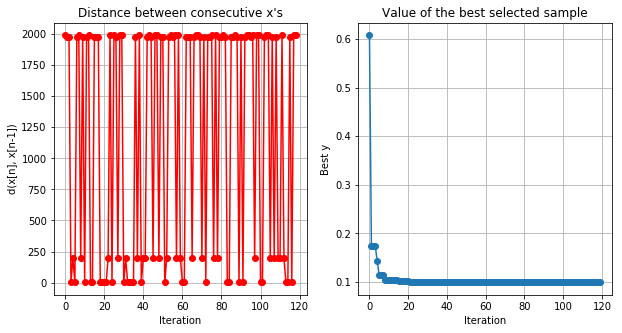

In [19]:
bayes_opt.plot_convergence()

In [20]:
min_index = np.argmin(bayes_opt.Y)
x_best = bayes_opt.X[min_index,:]
y_best = bayes_opt.Y[min_index,:]

print(x_best)
print(y_best)

[  -6.           -4.67597349  200.           20.        ]
[ 0.0991]


In [21]:
# Test candidate on the true objective
print(fit_svr_val(x_best))

[[ 0.0995]]


In [22]:
bayes_opt.save_report("mnist")

## Compare with random search

In the following, we will compare Bayesian optimisation with a random search strategy. The random search starts off with the same initial design of 20 points. Subsequently, we will run it for the same number of optimisation iterations, in which it randomly samples sets of hyperparameters.

In [23]:
class RandomOptimiser():
    def __init__(self, f, domain, X_init, Y_init):
        self.f = f
        self.domain = domain
        self.X = X_init
        self.Y = Y_init
    def run_optimization(self, n_iters):
        from GPyOpt.experiment_design import initial_design
        from GPyOpt.util.general import best_value
        X_new = initial_design('random', self.domain, n_iters)
        Y_new = np.zeros((n_iters))
        
        assert(self.X.shape[1] == X_new.shape[1])
        self.X = np.concatenate((self.X, X_new))
        Y_best_global = np.min(self.Y)
        
        for i in range(n_iters):
            X_current = X_new[i,:]
            Y_current = self.f(X_current)
            if Y_current < Y_best_global:
                Y_best_global = Y_current
            Y_new[i] = Y_current

        self.Y = np.append(self.Y, Y_new)
        self.Y_best = best_value(self.Y)

In [24]:
random_opt = RandomOptimiser(f = fit_svr_val,
                             domain = bayes_opt.space, 
                             X_init = X_init, 
                             Y_init = Y_init)

In [25]:
start = time.time()
random_opt.run_optimization(n_iters=opt_iter)
end = time.time()
print("Time elapsed: {}".format(end-start))

Time elapsed: 3429.21983218


In [26]:
min_index = np.argmin(random_opt.Y)
x_best_random = random_opt.X[min_index,:]
y_best_random = random_opt.Y[min_index]

print(x_best_random)
print(y_best_random)

[   -5.79277575    -4.16679442   200.          2000.        ]
0.1012


In [27]:
fit_svr_val(x_best_random)

array([[ 0.1021]])

## Analysis of results

First, we take a look at the initial design of 20 points. Both Bayesian optimisation and random search will continue optimising based on the initial design. Note the best found validation error at the end of the initial stage.

Min validation error from initial design = 0.1012


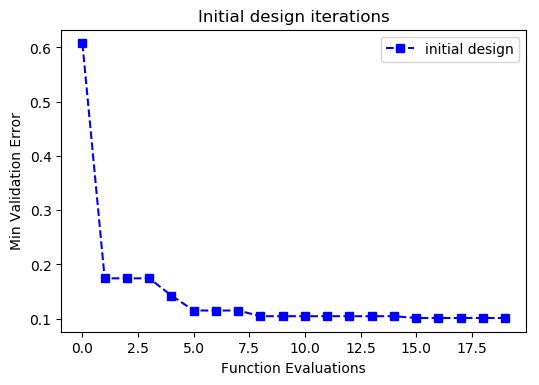

In [46]:
fig,ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
ax.plot(range(n_initial), random_opt.Y_best[:n_initial], '--bs', label='initial design')
plt.title('Initial design iterations')
plt.ylabel('Min Validation Error'); plt.xlabel('Function Evaluations');
plt.legend()
print("Min validation error from initial design = {}".format(np.min(random_opt.Y_best[:n_initial])))

Let's look at the optimisation profile for the subsequent iterations after the initial design.

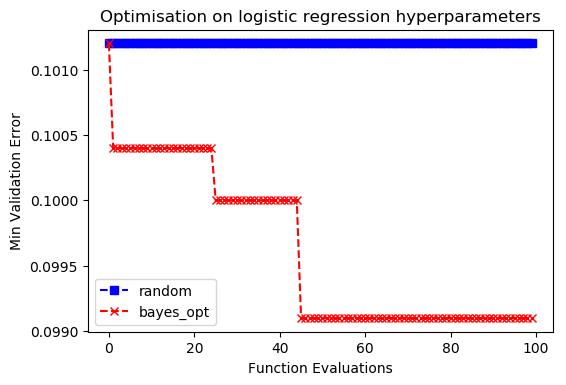

In [45]:
# Initialise plot
fig,ax = plt.subplots(1,1, figsize=(6, 4), dpi=100)
num_iter_random = len(random_opt.Y) - n_initial
num_iter_bayes = len(bayes_opt.Y) - n_initial
ax.plot(range(num_iter_random), random_opt.Y_best[n_initial:], '--bs', label='random')
ax.plot(range(num_iter_bayes), bayes_opt.Y_best[n_initial:], '--rx', label='bayes_opt')
plt.title('Optimisation on logistic regression hyperparameters')
plt.ylabel('Min Validation Error'); plt.xlabel('Function Evaluations');
plt.legend()

Evidently, Bayesian optimisation manages to reduce the min validation error by fine-tuning the hyperparameters. On the other hand, random search fails to improve on our best candidate from the initial design. 

Finally, when we compare the execution time of BayesOpt against RandomSearch, we notice in this case that RandomSearch is about 400 seconds slower, probably because it chose a couple of costly designs. In this use-case, the overall algorithmic overhead from using Bayesian optimisation is outweighed by the cost of each function evaluation. 

## Concluding remarks
Using the optimal hyperparameters, we can now train our final classification model.

In [36]:
gamma = np.exp(x_best[0]) # log scale
alpha = np.exp(x_best[1]) # log scale
n_iter = int(x_best[2])
batch_size = int(x_best[3])
clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, 
                    learning_rate='constant', eta0=gamma, 
                    n_iter=1)
for j in range(n_iter):
    for (X_batch, y_batch) in next_batch(X_train, y_train, batch_size):
        clf.partial_fit(X_batch, y_batch, classes=classes)

In [38]:
score = clf.score(X_test, y_test)
print("Optimal hyperparameters = {}".format(x_best))
print("Final classification error on validation set = {}".format(1-score))

Optimal hyperparameters = [  -6.           -4.67597349  200.           20.        ]
Final classification error on validation set = 0.0992


Lastly, the results obtained in this notebook compares quite favourably to similar results in the literature which typically achieves a validation error close to 0.07. 

__Reference__: 
https://papers.nips.cc/paper/4522-practical-bayesian-optimization-of-machine-learning-algorithms.pdf

In [48]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "img/mnist_paper_results.png", width=500, height=400)

### Visualising classification vectors for individual digits

Text(0.5,0.98,u'Classification vector for...')

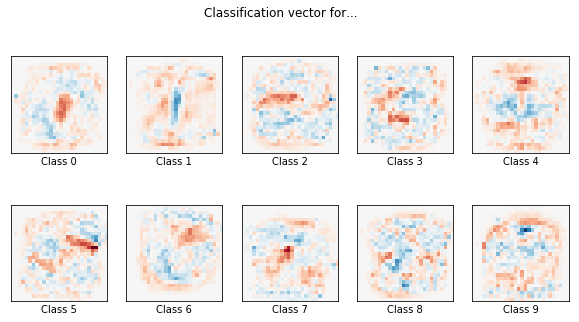

In [44]:
coef = clf.coef_.copy()
plt.figure(figsize=(10, 5))
scale = np.abs(coef).max()
for i in range(10):
    l1_plot = plt.subplot(2, 5, i + 1)
    l1_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.RdBu, vmin=-scale, vmax=scale)
    l1_plot.set_xticks(())
    l1_plot.set_yticks(())
    l1_plot.set_xlabel('Class %i' % i)
plt.suptitle('Classification vector for...')

## Saving results

In [57]:
import pickle
with open('mnist.pkl', 'w') as f:  # Python 3: open(..., 'wb')
    pickle.dump([bayes_opt.X, bayes_opt.Y, random_opt.X, random_opt.Y, clf], f)